In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# project modules
import os
import sys
import re
sys.path.insert(0, os.path.abspath('../../modules'))

import helper_functions as hf


### Read the data

In [4]:

#balanced_dataset = '/../../data/training/ber-rating-dataset-final.csv' # final balanced dataset
balanced_dataset = '/../../data/training/ber-rating-dataset-final-split_0.csv' # 1st split of balanced dataset

current_folder = os.path.abspath('.')

df = pd.read_table(current_folder + balanced_dataset, sep=";", encoding='cp437', header=0, on_bad_lines="warn")

# replace any spurious characters in feature names
# df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9]+', '', x))
# replace spaces in features names
df.columns = df.columns.str.strip().str.replace(" ", "").str.replace("[^\w]", "", regex=True)

print(df.shape)

df.head()


(27628, 212)


,index,CountyName,DwellingTypeDescr,Year_of_Construction,TypeofRating,EnergyRating,BerRating,GroundFloorAreasqm,UValueWall,UValueRoof,...,ThirdWallAgeBandId,ThirdWallTypeId,SA_Code,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC
0,5640,Dublin 20,Semi-detached house,1969,Existing,F,403.64,116.82,1.96,0.65,...,NaN,NaN,268037012,0.050000,0.050000,0.000,46510.4,0.00,2.369,2.630
1,13237,Co. Meath,Detached house,1979,Existing,A3,63.37,167.87,0.17,0.13,...,NaN,NaN,167050001,0.050000,0.050000,0.481,18939.2,9863.61,0.711,0.403
2,14229,Co. Dublin,Semi-detached house,1986,Existing,B2,106.61,107.02,0.60,0.32,...,NaN,NaN,267134021,0.000222,0.012347,0.289,12788.9,4641.45,0.681,0.704
3,17232,Co. Wexford,Detached house,1880,Existing,D2,298.69,123.76,1.62,0.25,...,NaN,NaN,247109003/247109004,0.050000,0.050000,0.000,36220.3,0.00,2.046,1.683
4,17096,Co. Longford,Detached house,1982,Existing,C2,196.09,113.09,0.60,0.16,...,NaN,NaN,137045007,0.050000,0.050000,0.207,24747.5,5503.68,1.430,1.135


In [5]:
df['EnergyRating'].value_counts()
#df.loc[df['EnergyRating'] == "A2"]

EnergyRating
F     1914
E2    1903
B1    1899
C3    1862
C2    1854
G     1853
C1    1845
D2    1841
A3    1829
A2    1826
E1    1815
D1    1814
A1    1803
B3    1795
B2    1775
Name: count, dtype: int64

In [6]:
# Counting NaN values in all columns
nan_count = df.isna().sum()

drop_columns = []

for column, value in nan_count.items():
  if value/(len(df)) > 0.5:
    drop_columns.append(column)

print(drop_columns)

df_1 = df.drop(drop_columns, axis=1, inplace=False)

print(df_1.shape)
clean_df = df_1.dropna()
clean_df.shape

['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFactor', 'CHPUnitHeatFraction', 'CHPSystemType', 'CHPElecEff', 'CHPHeatEff', 'CHPFuelType', 'SupplHSFuelTypeID', 'gsdSHRenewableResources', 'gsdWHRenewableResources', 'SolarHeatFraction', 'TotalDeliveredEnergy', 'DeliveredEnergySupplementaryWater', 'CO2SupplementaryWater', 'FirstEnerProdComment', 'FirstEnerConsumedComment', 'SecondEnerProdComment', 'SecondEnerConsumedComment', 'ThirdEnerProdComment', 'ThirdEnerConsumedComment', 'FirstBoi

(4187, 147)

<Axes: ylabel='count'>

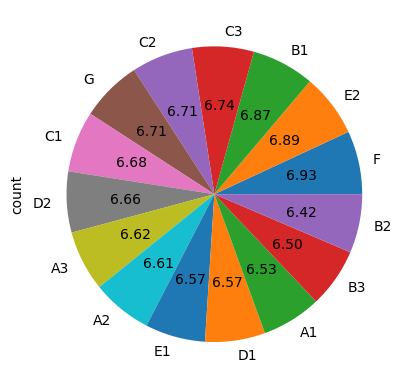

In [7]:
# check data to see if it is balanced
df['EnergyRating'].value_counts().plot.pie(autopct='%.2f')
#df.info(verbose=True, show_counts=True)

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop(['BerRating', 'EnergyRating'], axis='columns')
y_energy_rating = df[['EnergyRating']] # dependent variable
y_ber_rating = df[['BerRating']] 

X_train, X_test, y_energy_rating_train, y_energy_rating_test, y_ber_rating_train, y_ber_rating_test = train_test_split( X, y_energy_rating, y_ber_rating, test_size=0.2, shuffle=True,random_state=20)

X_train.shape, X_test.shape, y_energy_rating_train.shape, y_energy_rating_test.shape, y_ber_rating_train.shape, y_ber_rating_test.shape


((22102, 210), (5526, 210), (22102, 1), (5526, 1), (22102, 1), (5526, 1))

### Balance Dataset

In [9]:

# balance training data
X_train_merged = pd.concat([X_train, y_energy_rating_train], axis='columns')

X_train_res_merged, y_energy_rating_train_balanced = hf.feature_balance_data(X_train_merged, y_energy_rating_train)
X_train_balanced = X_train_res_merged.drop('EnergyRating', axis='columns')
y_energy_rating_train_balanced_2 = X_train_res_merged[['EnergyRating']]

# outputs - the total rows should be the same
[X_train_balanced.shape, y_energy_rating_train_balanced.shape, y_energy_rating_train_balanced_2.shape]

#print(type(X_train_merged))

all_vals: <class 'list'>
15
target_stats:  Counter({'C3': 1418, 'C1': 1418, 'D2': 1418, 'D1': 1418, 'A1': 1418, 'G ': 1418, 'B1': 1418, 'B2': 1418, 'C2': 1418, 'A2': 1418, 'B3': 1418, 'A3': 1418, 'F ': 1418, 'E2': 1418, 'E1': 1418})


[(21270, 210), (21270, 1), (21270, 1)]

In [10]:
# sum NaN's for each column
#for column_name in X_train_balanced:
#  print(X_train_balanced[column_name].isnull().sum())

<Axes: ylabel='count'>

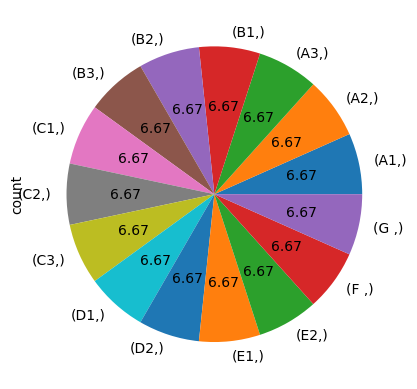

In [11]:
# check data to see if it is balanced
y_energy_rating_train_balanced.value_counts().plot.pie(autopct='%.2f')

### Pipeline for LightGBM

In [17]:
import datetime as dt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import lightgbm as lgb

# custom transformer classes
from tfidf_transformer import TfidfTransformer
from drop_features_transformer import DropFeaturesTransformerSingleton
from numerical_column_selector import NumericalColumnSelector
from categorical_column_selector import CategoricalColumnSelector
from save_feature_names_transformer import SaveFeatureNamesTransformerSingleton

from sklearn import set_config
#set_config(transform_output="pandas")

# various logging functions 

def features_logging(df):
    print('features_logging 1: ', type(df))
    if isinstance(df, pd.DataFrame):
        print('features_logging 2: ', df.columns.values.tolist())    
        #print(df.head())
    print('features_logging 3: ', df.shape)
    return df

def numerical_features_logging(df):
    print('numerical_features_logging 1: ', type(df))
    if isinstance(df, pd.DataFrame):
        numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
        print('numerical_features_logging 2: ', df[numerical_features].describe())    
        #print(df.head())
    print('numerical_features_logging 3: ', df.shape)
    return df

def features_logging_to_file(df):
    print('features_logging_to_file 1: ', type(df))
    print(df)
    print(df.shape)
    
    df_new = None

    if not isinstance(df, pd.DataFrame):
        # convert to dataframe
        features = SaveFeatureNamesTransformerSingleton().get_feature_names()
        print('features:', len(features))
        df_new = pd.DataFrame(df, columns=features)
        print(df_new.head())

    #print('features_logging_to_file 3: ', df.shape)
    if isinstance(df_new, pd.DataFrame):
        print('features_logging_to_file 4: dataframe - saving to file')
        curr_date_time = dt.datetime.now().strftime("%d%m%Y-%H%M%S")
        df_new.to_csv(current_folder + balanced_dataset + '_save_' + curr_date_time, sep=';', encoding='utf-8')
    else:
        print('features_logging_to_file 5: numpy array - can\'t save to file')
    return df

# Pipeline
#
# function transformers
clean_up_features_transformer = FunctionTransformer(hf.clean_up_features)
feature_main_heating_fuel_transformer = FunctionTransformer(hf.feature_main_heating_fuel)
feature_suspended_wooden_floor_transformer = FunctionTransformer(hf.feature_suspended_wooden_floor)
feature_ventilation_method_transformer = FunctionTransformer(hf.feature_ventilation_method)
features_convert_to_boolean = FunctionTransformer(hf.features_convert_to_boolean)
features_logging = FunctionTransformer(features_logging, feature_names_out='one-to-one')
numerical_features_logging = FunctionTransformer(numerical_features_logging, feature_names_out='one-to-one')
features_logging_to_file = FunctionTransformer(features_logging_to_file, feature_names_out='one-to-one')

# numeric processing pipeline
simple_imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
simple_imputer.set_output(transform='pandas')
min_max_scaler = MinMaxScaler()
min_max_scaler.set_output(transform='pandas')

numeric_processor = Pipeline(
    steps=[
            ('imputation_nan_to_zero', simple_imputer),
            ('Scaler', min_max_scaler),
            ('Numerical Feature Logging - n 2', numerical_features_logging),
            ('num_save_feature_names', SaveFeatureNamesTransformerSingleton(logging=True))  
            ])

# categorical processing pipeline
category_processor = Pipeline(
    steps=[
            ('feature_main_heating_fuel', feature_main_heating_fuel_transformer),
            ('feature_suspended_wooden_floor', feature_suspended_wooden_floor_transformer),
            ('feature_ventilation_method', feature_ventilation_method_transformer),
            ('features_convert_to_boolean', features_convert_to_boolean),
            ('feature_categorical_features_using_tf_idf', TfidfTransformer()),
            ('cat_save_feature_names', SaveFeatureNamesTransformerSingleton(logging=True))           
            ])

# determine categorical and numerical features
params_drop_features = {'logging': True}
dft_singleton = DropFeaturesTransformerSingleton(**params_drop_features)

# combining processing techniques
preprocessor = ColumnTransformer(
    [
        ('categorical', category_processor, CategoricalColumnSelector(drop_features_transformer_singleton=dft_singleton, logging=params_drop_features)), 
        ('numerical', numeric_processor, NumericalColumnSelector(drop_features_transformer_singleton=dft_singleton, logging=params_drop_features))
        ])

#num_leaves=108, learning_rate=0.15, max_depth=30, n_estimators=200, reg_alpha=1, reg_lambda=1
param_initial = {
        'metric': 'rmse',
        #'boosting': 'dart', 
        #'random_state': 48,
        'n_estimators': 200,
        'num_leaves': 108, 
        'learning_rate': 0.15, 
        'max_depth': 35, 
        #'bagging_freq': 1, 
        'feature_fraction': 0.9,
        #'min_gain_to_split': 1,
        'reg_alpha': 0.01,
        'reg_lambda': 0.01
}

params_classifier = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "n_estimators": 200,
    "verbosity": -1,
    "bagging_freq": 1
}

pipe1 = Pipeline([('Clean up features', clean_up_features_transformer),
            ('Drop features', dft_singleton),      
            ('Feature Logging 3', features_logging),
            ('preprocessor', preprocessor),
            ('Feature Logging 4', features_logging_to_file),
            #('LightGBM', lgb.LGBMClassifier(**param_initial))
            ('LightGBM', lgb.LGBMClassifier())
            ])

In [18]:
pipe1


Pipeline(steps=[('Clean up features',
                 FunctionTransformer(func=<function clean_up_features at 0x000002377A7180E0>)),
                ('Drop features', DropFeaturesTransformerSingleton()),
                ('Feature Logging 3',
                 FunctionTransformer(feature_names_out='one-to-one',
                                     func=<function features_logging at 0x000002371A46B420>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  P...
                                                                                       func=<function numerical_features_logging at 0x000002371A46BEC0>)),
                                                                  ('num_save_feature_names',
                                                                   SaveFeatureNamesTransformerSingleton())]),
                                                  <numerical_column_selector.NumericalColumnSelector object at 0x000002371A410D10>)])),
                ('Feature Logging 4',
                 FunctionTransformer(feature_names_out='one-to-one',
                                     func=<function features_logging_to_file at 0x000002371A5A9440>)),
                ('LightGBM', LGBMClassifier())])

### Baseline for LightGBM

In [19]:
# fit, predict, metrics
from sklearn.metrics import classification_report

print('X_train_balanced: ', type(X_train_balanced), X_train_balanced.shape)
print('y_energy_rating_train_balanced: ', type(y_energy_rating_train_balanced), y_energy_rating_train_balanced.shape)
print('X_test: ', type(X_test), X_test.shape)
print('y_energy_rating_test: ', type(y_energy_rating_test), y_energy_rating_test.shape)

pipe1.fit(X_train_balanced, y_energy_rating_train_balanced.values.ravel())
score = pipe1.score(X_test, y_energy_rating_test)

y_preds = pipe1.predict(X_test)


X_train_balanced:  <class 'pandas.core.frame.DataFrame'> (21270, 129)
y_energy_rating_train_balanced:  <class 'pandas.core.frame.DataFrame'> (21270, 1)
X_test:  <class 'pandas.core.frame.DataFrame'> (5526, 210)
y_energy_rating_test:  <class 'pandas.core.frame.DataFrame'> (5526, 1)
DropFeaturesTransformerSingleton - fit
DropFeaturesTransformerSingleton: Test
DropFeaturesTransformerSingleton - transform end - self.nan_features_to_drop: ['StorageLosses', 'ManuLossFactorAvail', 'SolarHotWaterHeating', 'ElecImmersionInSummer', 'CombiBoiler', 'KeepHotFacility', 'WaterStorageVolume', 'DeclaredLossFactor', 'TempFactorUnadj', 'TempFactorMultiplier', 'InsulationType', 'InsulationThickness', 'PrimaryCircuitLoss', 'CombiBoilerAddLoss', 'ElecConsumpKeepHot', 'ApertureArea', 'ZeroLossCollectorEff', 'CollectorHeatLossCoEff', 'AnnualSolarRadiation', 'OvershadingFactor', 'SolarStorageVolume', 'VolumeOfPreHeatStore', 'ElectricityConsumption', 'gsdHSSupplHeatFraction', 'gsdHSSupplSystemEff', 'DistLossFac

### Classification Report

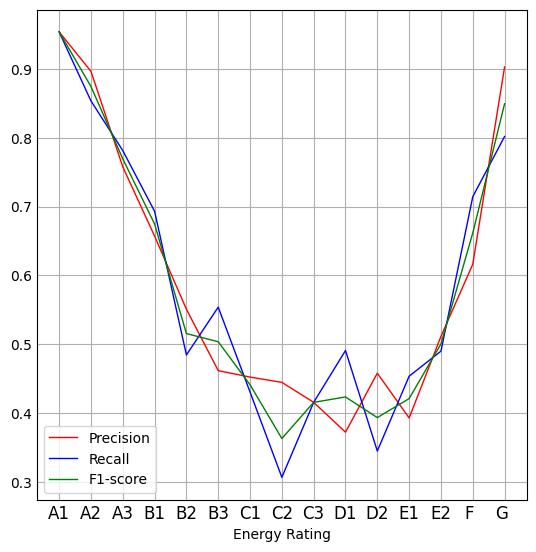

In [20]:
# reports
y_labels = sorted(y_energy_rating_test['EnergyRating'].unique())
x_len = len(y_labels)

# classification metrics
report = classification_report(y_energy_rating_test, y_preds, output_dict=True)

plt.style.use('_mpl-gallery')

# get data
x =  np.linspace(0, 1, x_len)
precision = []
recall = []
f1_score = []

for key in y_labels:
  precision.append(report[key]['precision'])
  recall.append(report[key]['recall'])
  f1_score.append(report[key]['f1-score'])

# plot
#cmap = plt.cm.coolwarm
fig_cr, ax_cr = plt.subplots(figsize=(5, 5))
ax_cr.plot(x, precision, color='red', label='Precision', linewidth=1.0)
ax_cr.plot(x, recall, color='blue', label='Recall', linewidth=1.0)
ax_cr.plot(x, f1_score, color='green', label='F1-score', linewidth=1.0)

# Set number of ticks for x-axis
ax_cr.set_xticks(x)
# Set ticks labels for x-axis
ax_cr.set_xticklabels(y_labels, rotation=0, fontsize=12)
ax_cr.set_xlabel('Energy Rating')
ax_cr.set_ylabel('')
plt.legend(loc='best')

plt.show()

### Confusion Matrix

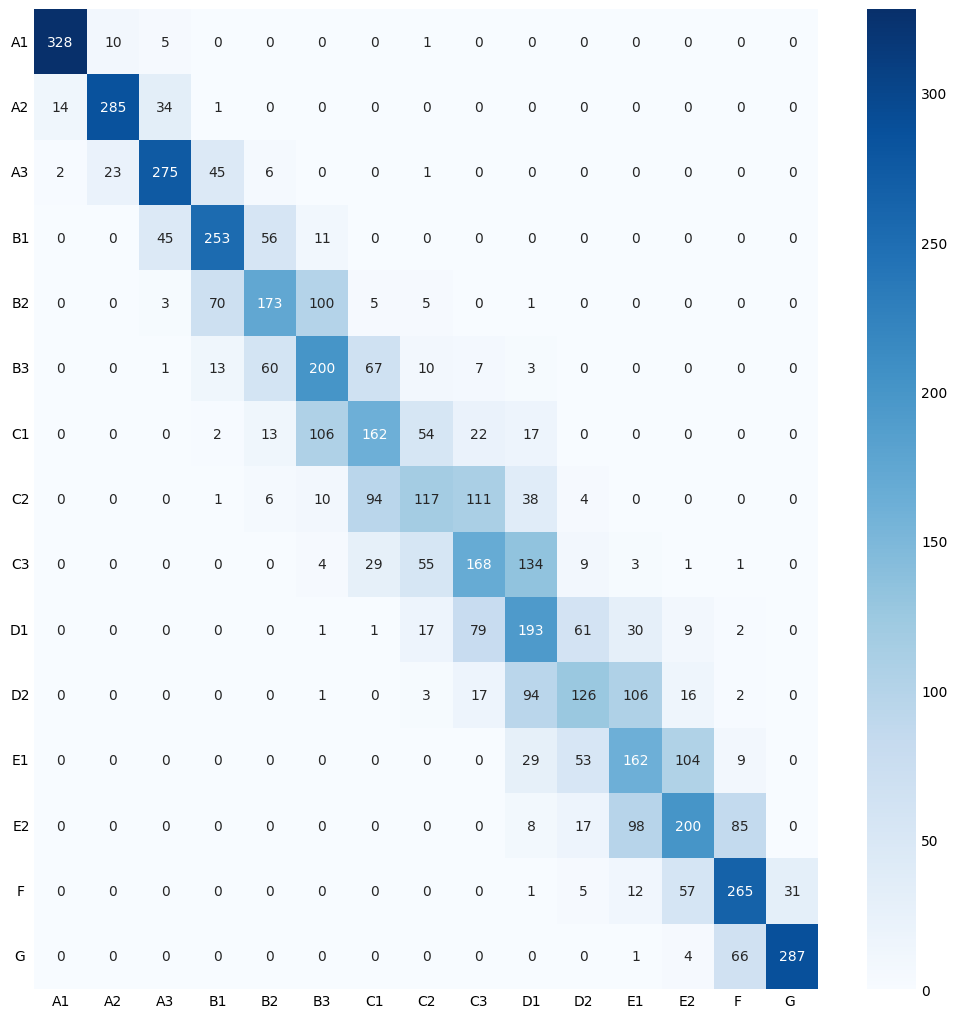

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_energy_rating_test, y_preds)

df_matrix = pd.DataFrame(cf_matrix, index=y_labels, columns=y_labels)
plt.figure(figsize=(10, 10))
sns_matrix = sns.heatmap(df_matrix, annot=True, cmap='Blues', fmt='g') # annot_kws={"size": 35 / np.sqrt(len(df_matrix))}
sns_matrix.set_yticklabels(sns_matrix.get_yticklabels(), rotation=0)
plt.show()

### Optuna for LightGBM

In [ ]:
# optuna
import optuna
from sklearn.metrics import accuracy_score

def objective(trial):
    
    global X_train_balanced, X_test, y_ber_rating_train_balanced, y_ber_rating_test

    # Define the parameter distributions for hyperparameter tuning
    # Using this guide: https://towardsdatascience.com/beginners-guide-to-the-must-know-lightgbm-hyperparameters-a0005a812702
    # Parameter documentation: https://lightgbm.readthedocs.io/en/latest/Parameters.html

    params = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "n_estimators": 500,
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 0.003, 0.25, log=True), # Default is 0.1
        "num_leaves": trial.suggest_int("num_leaves", 8, 256), # Default is 31
        "max_depth": trial.suggest_int("max_depth", 10, 30),  # Default is -1
        "min_child_samples": trial.suggest_int("min_data_in_leaf", 1, 100),  # Default is 20. AKA min_data_in_leaf.
        "subsample": trial.suggest_float("subsample", 0.5, 1.0), # Default is 1. AKA bagging_fraction.
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),  # Default is 1.0. AKA colsample_bytree.
        "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 1),  # Default is 0. AKA lambda_l1.
        "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 1)  # Default is 0. AKA lambda_l2.
    }

    pipe2 = Pipeline([('Clean up features', clean_up_features_transformer),
            ('Drop features', dft_singleton),      
            ('preprocessor', preprocessor),
            ('LightGBM', lgb.LGBMClassifier(**params))
            ])

    pipe2.set_params(LightGBM__stopping_rounds=20).fit(X_train_balanced, y_energy_rating_train_balanced.values.ravel()).score(X_test, y_energy_rating_test)
    preds = pipe2.predict(X_test)
    accuracy = accuracy_score(y_energy_rating_test, preds)
    
    return accuracy

In [ ]:
sampler = optuna.samplers.TPESampler(seed=1)
study = optuna.create_study(study_name="lightGBM", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=20)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
study.trials_dataframe()

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best multi_logloss:', study.best_value)

### Results for LightGBM Classifier using optimised parameters from Optuna

In [ ]:
# Best parms - copied from above
#best_params = {'learning_rate': 0.13878295273718808, 'num_leaves': 230, 'max_depth': 29, 'min_data_in_leaf': 56, 'subsample': 0.5324168009765406, 'feature_fraction': 0.8470566171420315, 'reg_alpha': 0.9819147551958919, 'reg_lambda': 0.575487906743726}
#best_params = {"n_estimators": 2000, "verbosity": -1, "bagging_freq": 1,'learning_rate': 0.028702779348242745, 'num_leaves': 156, 'max_depth': 27, 'min_data_in_leaf': 45, 'subsample': 0.5441572154935997, 'feature_fraction': 0.7098507201339125, 'reg_alpha': 0.31244262813284635, 'reg_lambda': 0.6037510487589504}
best_params = {"n_estimators": 2000, "verbosity": -1, "bagging_freq": 1, 'learning_rate': 0.03853760378058098, 'num_leaves': 59, 'max_depth': 27, 'min_data_in_leaf': 63, 'subsample': 0.8950210378605308, 'feature_fraction': 0.7545552753895864, 'reg_alpha': 0.7820124418196901, 'reg_lambda': 0.5481419089874953}

pipe3 = Pipeline([('Clean up features', clean_up_features_transformer),
            ('Drop features', dft_singleton),      
            ('preprocessor', preprocessor),
            #('dbg', Debug()),
            #('Feature Logging', features_logging),
            ('LightGBM', lgb.LGBMClassifier(**best_params))
            ])

pipe3.fit(X_train_balanced, y_energy_rating_train_balanced.values.ravel())
score_3 = pipe3.score(X_test, y_energy_rating_test)

y_preds_3 = pipe3.predict(X_test)

# metrics
#print("R2: {:.3f}%".format(score*100) )
#print("Mean absolute error: " f"{mean_absolute_error(y_ber_rating_test, y_preds_3):.3f} kWh/m2/year")
#print("Median absolute error: " f"{median_absolute_error(y_ber_rating_test, y_preds_3):.3f} kWh/m2/year")
#print("Mean absolute percentage error: " f"{mean_absolute_percentage_error(y_ber_rating_test, y_preds_3) * 100:.3f} %")
#print("RMSE (mean squared error): " f"{mean_squared_error(y_ber_rating_test, y_preds_3, squared=False):.3f} %")

# classification metrics
report = classification_report(y_energy_rating_test, y_preds_3)
print(report)

### Comparison with HistGradientBoostingClassifier

In [ ]:
# Build HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier

# Best parms - copied from above
best_params = {"n_estimators": 2000, "verbosity": -1, "bagging_freq": 1,'learning_rate': 0.028702779348242745, 'num_leaves': 156, 'max_depth': 27, 'min_data_in_leaf': 45, 'subsample': 0.5441572154935997, 'feature_fraction': 0.7098507201339125, 'reg_alpha': 0.31244262813284635, 'reg_lambda': 0.6037510487589504}


pipe4 = Pipeline([('Clean up features', clean_up_features_transformer),
            ('Drop features', dft_singleton),      
            ('preprocessor', preprocessor),
            #('dbg', Debug()),
            #('Feature Logging', features_logging),
            ('HGBR', HistGradientBoostingClassifier())
            ])

pipe4.fit(X_train_balanced, y_energy_rating_train_balanced.values.ravel())
score_4 = pipe4.score(X_test, y_energy_rating_test)

y_preds_4 = pipe4.predict(X_test)

# classification metrics
report = classification_report(y_energy_rating_test, y_preds_4)
print(report)

### Explainable Boosting Machine

In [ ]:
# Build ExplainableBoostingClassifier

from sklearn.metrics import roc_auc_score

from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

# Best parms - copied from above
best_params = {"n_estimators": 2000, "verbosity": -1, "bagging_freq": 1,'learning_rate': 0.028702779348242745, 'num_leaves': 156, 'max_depth': 27, 'min_data_in_leaf': 45, 'subsample': 0.5441572154935997, 'feature_fraction': 0.7098507201339125, 'reg_alpha': 0.31244262813284635, 'reg_lambda': 0.6037510487589504}


pipe5 = Pipeline([('Clean up features', clean_up_features_transformer),
            ('Drop features', dft_singleton),      
            ('preprocessor', preprocessor),
            #('dbg', Debug()),
            #('Feature Logging', features_logging),
            ('HGBR', ExplainableBoostingClassifier())
            ])

pipe5.fit(X_train_balanced, y_energy_rating_train_balanced.values.ravel())
score_5 = pipe5.score(X_test, y_energy_rating_test)

y_preds_5 = pipe5.predict(X_test)

# classification metrics
report = classification_report(y_energy_rating_test, y_preds_5)
print(report)

# 
#auc = roc_auc_score(y_energy_rating_test, pipe5.predict_proba(X_test)[:, 1])
#print("AUC: {:.3f}".format(auc))

In [ ]:
feature_names = X_test.columns

In [ ]:
print(feature_names[60])
pipe5

In [ ]:
print(X_test['DeliveredEnergyMainWater'])

In [ ]:
# extract EBM from pipeline and then pass to explain_global
EBM = pipe5['HGBR']
ebm_global = EBM.explain_global(name='HGBR')
show(ebm_global)

In [ ]:
EBM_2 = EBM.copy()

In [ ]:
#print(EBM_2.feature_names_in_)
feature_names_2 = SaveFeatureNamesTransformerSingleton().get_feature_names()
print(len(feature_names_2))
EBM_2.feature_names_in_ = feature_names_2

In [ ]:
print(feature_names_2[30:50])

In [ ]:
ebm_global_2 = EBM_2.explain_global(name='HGBR')
show(ebm_global_2)

In [ ]:
# processed test 
X_test_processed_dataset = '/../../data/training/ber-rating-dataset-final-split_0.csv_save_08042024-230135' # balanced dataset

current_folder = os.path.abspath('.')

df_processed = pd.read_table(current_folder + X_test_processed_dataset, sep=";", encoding='cp437', header=0, on_bad_lines="warn")

# replace any spurious characters in feature names
# df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9]+', '', x))
# replace spaces in features names
df_processed.columns = df_processed.columns.str.strip().str.replace(" ", "").str.replace("[^\w]", "", regex=True)
df_processed.drop('Unnamed0', axis='columns', inplace=True)

print(df_processed.shape)
print(df_processed.head())

print(y_energy_rating_test.shape)


In [ ]:
ebm_local_2 = EBM_2.explain_local(df_processed[:5], y_energy_rating_test[:5], 0)
show(ebm_local_2)

In [ ]:
# multi_class = ovo, ovr
auc = roc_auc_score(y_energy_rating_test, pipe5.predict_proba(X_test), multi_class='ovo')
print("AUC: {:.3f}".format(auc))